# Import libraries

In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

from data import parallel_line, orthogonal, triangle, lines_3D, real_data_loader, add_noise_data
from models import Autoencoder
from train import train_AE, train_TAE

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Toy data 

## Visualize
use `parallel_line`, `orthogonal`, `triangle`, `lines_3D` for different toy datasets

Text(0.5, 1.0, 'true dataset')

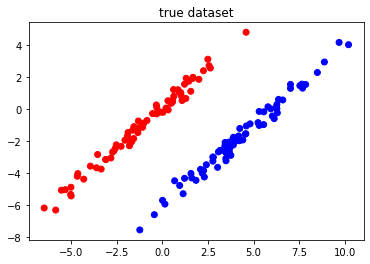

In [3]:
# change parallel_lines to orthogonal, triangle, lines_3D for other toy datasets
X,Y, X_noise, n_clusters = parallel_line(noise=0)

color= ['red' if l == 0 else 'blue' if l == 1 else 'green' for l in Y.cpu().detach().numpy()]
plt.scatter(X[:,0],X[:,1], color = color)
plt.title('true dataset')

## Clustering
Use linear Autoencoder since the underlying structures are linear.
* Hyperparameters in the setting include <br>
`cnn = False` -- set to True for mnist and fashion <br>
`epochs = 200` -- change for testing <br>
`lr` -- learning rate in `train_AE` and `train_TAE` <br>
`reg` -- regularisation strength in `train_TAE`

* Set `repetition` to number of times the experiment to be repeated

**`kmeans_ari`, `ae_ari`, `tae_ari` are the lists of ari scores for the datasets ran for `repetition` number of times**

In [10]:
# kmeans_ari, ae_ari, tae_ari gives the ari of respective algorithms
# hyperparameters: repetition, epochs, lr, reg,  
repetition = 10
epochs = 200

np.random.seed(1)
ae_ari = []
tae_ari = []
kmeans_ari = []
ae_err = []
tae_err = []

for (data_generation, lr) in [(parallel_line(noise=0), 0.01), 
                              (orthogonal(noise=0), 0.01), 
                              (triangle(noise=0),0.1), 
                              (lines_3D(noise=0),0.1)]:
    ae = []
    tae = []
    kmeans_ = []
    ae_e = []
    tae_e = []
    for rep in range(repetition):
        print(rep)

        np.random.seed(rep)

        X,Y,X_noise,n_clusters = data_generation
        x_idx = torch.tensor(np.arange(X.shape[0]))
        shuffle_idx = torch.randperm(x_idx.shape[0])
        x_idx = x_idx[shuffle_idx].long()
        X = torch.tensor(X[x_idx], dtype=torch.float).to(device)
        Y = torch.tensor(Y[x_idx])
        
        # k means
        k = KMeans(n_clusters=n_clusters, random_state=rep).fit(X.cpu().detach().numpy())
        k_ari = adjusted_rand_score(k.labels_, Y)
        kmeans_.append(k_ari)
        
        # Standard AE
        net = Autoencoder(in_feature=X.shape[1],embed=1)
        ae_l = train_AE(net, X,Y, lr=0.01,epochs=epochs)
        ae_e.append(ae_l[-1])
        
        X_embed = net.enc1(X).cpu().detach().numpy()
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_embed)
        AE_clust_assign = kmeans.labels_
        ari = adjusted_rand_score(AE_clust_assign, Y)
        ae.append(ari)
        
        # Tensorized AE
        _, tae_l, TAE_clust_assign, _, _, _ = train_TAE(X.clone(),Y.clone(), n_clusters=n_clusters, lr=lr, reg=0.1, embed=1, epochs=epochs )
        tae_e.append(tae_l[-1])
        ari = adjusted_rand_score(torch.argmax(TAE_clust_assign,axis=0).cpu().detach().numpy(), Y)
        tae.append(ari)
        
    kmeans_ari.append(kmeans_)    
    ae_ari.append(ae)
    tae_ari.append(tae)
    ae_err.append(ae_e)
    tae_err.append(tae_e)
    
#consider only best 5 based on the loss
kmeans_ari = np.sort(np.array(kmeans_ari))[::-1][:5]
ae_idx = np.argsort(np.array(ae_err))[:5]
ae_ari = ae_ari[ae_idx]
tae_idx = np.argsort(np.array(tae_err))[:5]
tae_ari = tae_ari[tae_idx]

0
torch.FloatTensor


<ipython-input-10-e98f35f9a3c7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X[x_idx], dtype=torch.float).to(device)
<ipython-input-10-e98f35f9a3c7>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y[x_idx])


epoch  49  loss  3.1431946883893884
epoch  99  loss  3.1431942228375314
epoch  149  loss  3.143194209491679
epoch  199  loss  3.1431942051113584
epoch  49  loss  1.3761858778695266
epoch  99  loss  1.5071651403668027
epoch  149  loss  1.1360333086208751
epoch  199  loss  1.0844270652905106
0
torch.FloatTensor


<ipython-input-10-e98f35f9a3c7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X[x_idx], dtype=torch.float).to(device)
<ipython-input-10-e98f35f9a3c7>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y[x_idx])


epoch  49  loss  2.222626495755588
epoch  99  loss  2.2226262881358463
epoch  149  loss  2.222625902183354
epoch  199  loss  2.222625919125664
epoch  49  loss  1.2738250528182835
epoch  99  loss  3.258650661620001
epoch  149  loss  3.396592739497622
epoch  199  loss  3.392653705275928
0
torch.FloatTensor


<ipython-input-10-e98f35f9a3c7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X[x_idx], dtype=torch.float).to(device)
<ipython-input-10-e98f35f9a3c7>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y[x_idx])


epoch  49  loss  4.5762676030428455
epoch  99  loss  4.576270476675902
epoch  149  loss  4.576270712933813
epoch  199  loss  4.57627065571025
epoch  49  loss  1.1626169138910094
epoch  99  loss  1.1612366218449703
epoch  149  loss  1.1612294193803487
epoch  199  loss  1.1612293874561632
0
torch.FloatTensor


<ipython-input-10-e98f35f9a3c7>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X[x_idx], dtype=torch.float).to(device)
<ipython-input-10-e98f35f9a3c7>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y[x_idx])


epoch  49  loss  0.7551702471706085
epoch  99  loss  0.7551702762045898
epoch  149  loss  0.7551702698747007
epoch  199  loss  0.7551702737583158
epoch  49  loss  0.38199814780498853
epoch  99  loss  0.376921838002551
epoch  149  loss  0.37691636228468267
epoch  199  loss  0.37691529100198146


## Denoising

* Hyperparameters: <br>
`noise=0.1` -- noise level to add to the original data <br>
`epochs = 100` -- number of epochs <br>
`linear_ae = False` -- linear or relu Autoencoder <br>
`lr` -- learning rate in `train_AE` and `train_TAE` <br>
`reg` -- regularisation strength in `train_TAE`
* Set the following parameters accordingly <br>
`repetition= 5` -- number of times to repeat the experiment
`n_clusters = 3` -- length of `class_labels_list` in the `real_data_loader` function

**`ae_loss`, `tae_loss` are the lists of mse errors for the datasets ran for `repetition` number of times**

In [12]:
# ae_loss and tae_loss has the mse of the data
repetition = 5
epochs = 100

np.random.seed(1)
ae_loss = []
tae_loss = []
for data_generation in [parallel_line(noise=0.1) , orthogonal(noise=0.1), triangle(noise=0.1), lines_3D(noise=0.1)]:
    ae = []
    tae = []
    for rep in range(repetition):
        print(rep)

        np.random.seed(rep)

        X,Y,X_noise,n_clusters = data_generation

        # Standard AE
        net = Autoencoder(in_feature=X.shape[1],embed=1)
        ae_l = train_AE(net, X_noise,Y, lr=0.01,epochs=epochs,X_out=X)
        ae.append(ae_l[-1])

        # Tensorized AE
        _, tae_l, _, _, _, _ = train_TAE(X_noise.clone(),Y.clone(), n_clusters=n_clusters, lr=0.1, reg=0.1, embed=1, epochs=epochs, X_out=X.clone() )
        tae.append(tae_l[-1])
    
    ae_loss.append(ae)
    tae_loss.append(tae)

0
torch.DoubleTensor
epoch  49  loss  2.0990931867746014
epoch  99  loss  2.099091598922387
epoch  49  loss  1.8175959696643986
epoch  99  loss  1.8155231752386316
0
torch.DoubleTensor
epoch  49  loss  11.080445218795212
epoch  99  loss  11.080444827693281
epoch  49  loss  1.0605634540847193
epoch  99  loss  1.0591231883193055
0
torch.DoubleTensor
epoch  49  loss  4.712811161171024
epoch  99  loss  4.712913525899252
epoch  49  loss  1.0260984161278854
epoch  99  loss  1.444610231326272
0
torch.DoubleTensor
epoch  49  loss  0.807942114927185
epoch  99  loss  0.8079475769749842
epoch  49  loss  0.43262947076233105
epoch  99  loss  0.4770887397020124


# Real Data

## Clustering
* pass `real_data_loader` with the following arguments for different datasets: <br>
penguin4:  `dataset='penguin4', class_labels_list=[0,1,2], normalise_data=True, subsample=False` <br>
iris:     `dataset='iris', class_labels_list=[0,1,2], normalise_data=False, subsample=False` <br>
mnist:    `dataset='mnist', class_labels_list=[0,1,2,3,4], num_samples=200, normalise_data=False, subsample=True` <br>
fashion:  `dataset='fashion', class_labels_list=[0,1,2,3,4], num_samples=200, normalise_data=False, subsample=True` <br>
    
* Hyperparameters in the setting include <br>
`cnn = False` -- set to True for mnist and fashion <br>
`epochs = 200` -- change for testing <br>
`linear = False` -- whether to use linear or relu Autoencoder <br>
`lr` -- learning rate in `train_AE` and `train_TAE` <br>
`reg` -- regularisation strength in `train_TAE`

* Set `repetition` to number of times the experiment to be repeated

**`kmeans_ari`, `ae_ari_1`, `ae_ari_2`, `tae_ari` are the lists of ari scores for the datasets ran for `repetition` number of times**

In [5]:
repetition = 1
cnn = False
epochs = 200
linear = False

kmeans_ari = []
ae_ari_1 = []
ae_ari_2 = []
tae_ari = []

for r in range(repetition):

    ##################################
    # penguin 4 Features
    ##################################

    # load data

    X,Y = real_data_loader(dataset='penguin4', class_labels_list=[0,1,2], normalise_data=True, subsample=False)
    n_clusters = 3

    # k-means Benchmark
    k = KMeans(n_clusters=n_clusters, random_state=r).fit(X)
    kmeans_ari.append(adjusted_rand_score(k.labels_, Y.cpu().detach().numpy()))
    
    # simple AE embedding 1 
    net = Autoencoder(in_feature=X.shape[1],embed=1,linear=linear).to(device)
    train_loss = train_AE(net, X.float(),Y.float(), lr=0.001,epochs=epochs, CNN=cnn)

    X_embed = net.enc1(X.float().to(device)).cpu().detach().numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_embed)

    ae_ari_1.append(adjusted_rand_score(kmeans.labels_, Y.cpu().detach().numpy()))
    
    # simple AE embedding 3

    net = Autoencoder(in_feature=X.shape[1],embed=3,linear=linear).to(device)
    train_loss = train_AE(net, X.float(),Y.float(), lr=0.001,epochs=epochs, CNN=cnn)

    X_embed = net.enc1(X.float().to(device)).cpu().detach().numpy()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_embed)

    ae_ari_2.append(adjusted_rand_score(kmeans.labels_, Y.cpu().detach().numpy()))
    
    # TAE

    _, train_loss, clust_assign, _, Y_t, _ = train_TAE(X.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.01, reg=0.1, embed=1, linear=linear, epochs=epochs ,number_of_batches=1)

    tae_ari.append(adjusted_rand_score(torch.argmax(clust_assign,axis=0).cpu().detach().numpy(), Y_t.cpu().detach().numpy()))
    

torch.FloatTensor
epoch  49  loss  0.010621612802326322
epoch  99  loss  0.010621613241497895
epoch  149  loss  0.010621613241497895
epoch  199  loss  0.010621613241497895
torch.FloatTensor
epoch  49  loss  0.010633039277069226
epoch  99  loss  0.010621629720888363
epoch  149  loss  0.01062162497504698
epoch  199  loss  0.010621613175970709
epoch  49  loss  0.002193905857419888
epoch  99  loss  0.0020580841383905832
epoch  149  loss  0.0020067925777080297
epoch  199  loss  0.0019824241809653256


In [6]:
print(ae_ari_1,ae_ari_2,tae_ari)

[0.20959929307188535] [0.20959929307188535] [0.7523859980476766]


## Denoising
* `real_data_loader` : use the above arguments for different datasets 
* Hyperparameters: <br>
`noise=0.1` -- noise level to add to the original data <br>
`epochs = 100` -- number of epochs <br>
`linear_ae = False` -- linear or relu Autoencoder <br>
`lr` -- learning rate in `train_AE` and `train_TAE` <br>
`reg` -- regularisation strength in `train_TAE`
* Set the following parameters accordingly <br>
`repetition= 5` -- number of times to repeat the experiment
`n_clusters = 3` -- length of `class_labels_list` in the `real_data_loader` function

**`ae_mse`, `tae_mse` are the lists of mse errors for the datasets ran for `repetition` number of times**

In [9]:
#give different dataset name = ['penguin4', 'penguin2', 'iris', 'mnist', 'fashion']
X,Y = real_data_loader(dataset='penguin4', class_labels_list=[0,1,2], normalise_data=True, subsample=False)
X_noise = add_noise_data(X, noise=0.1)

repetition = 5
n_clusters = 3
epochs = 100
linear_ae = False

ae_mse = []
tae_mse = []

for i in range(repetition):
    # simple AE embedding 1 
    net = Autoencoder(in_feature=X.shape[1],embed=1, linear=linear_ae).to(device)
    train_loss = train_AE(net, X_noise.float(),Y.float(), lr=0.001,epochs=epochs, X_out=X)
    ae_mse.append(train_loss[-1])

    # TAE
    _, train_loss, _, _, _, _ = train_TAE(X_noise.float().clone(),Y.float().clone(), n_clusters= n_clusters , lr=0.01, reg=0.1, embed=1, epochs=epochs, linear=linear_ae ,number_of_batches=1, X_out=X.clone())
    tae_mse.append(train_loss[-1])
print(ae_mse, tae_mse)

torch.FloatTensor
epoch  49  loss  0.013262092726288397
epoch  99  loss  0.013262092904745417
epoch  49  loss  0.0031330291646287684
epoch  99  loss  0.002996175687285304
torch.FloatTensor
epoch  49  loss  0.01326209261440421
epoch  99  loss  0.013262092730470984
epoch  49  loss  0.003178254760243504
epoch  99  loss  0.0030700940615950643
torch.FloatTensor
epoch  49  loss  0.013262092244593862
epoch  99  loss  0.013262092904745417
epoch  49  loss  0.003042863882807276
epoch  99  loss  0.002956405478814527
torch.FloatTensor
epoch  49  loss  0.013262092932280778
epoch  99  loss  0.013262093534573222
epoch  49  loss  0.0029413066730015628
epoch  99  loss  0.002453794809020665
torch.FloatTensor
epoch  49  loss  0.013262091879314649
epoch  99  loss  0.013262093212165519
epoch  49  loss  0.002704058888618915
epoch  99  loss  0.002609810747251871
[0.013262092904745417, 0.013262092730470984, 0.013262092904745417, 0.013262093534573222, 0.013262093212165519] [0.002996175687285304, 0.003070094061